- Summary
- Business Understanding\
   Apple looking to understand positive and negative sentiment around their products and how to improve. Focusing on neutral 
   and negative sentiment tweets as demographics to focus on.
- Data Understanding


In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [105]:
df = pd.read_csv("data/tweet_product_company.csv", encoding = 'latin-1')

In [106]:
df.tail()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product
9092,Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...,NaN,No emotion toward brand or product


In [107]:
df.describe()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
count,9092,3291,9093
unique,9065,9,4
top,RT @mention Marissa Mayer: Google Will Connect...,iPad,No emotion toward brand or product
freq,5,946,5389


In [108]:
df['tweet_text_lower'] = df['tweet_text'].str.lower()

In [109]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,tweet_text_lower
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,.@wesley83 i have a 3g iphone. after 3 hrs twe...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,@jessedee know about @fludapp ? awesome ipad/i...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,@swonderlin can not wait for #ipad 2 also. the...
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,@sxsw i hope this year's festival isn't as cra...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,@sxtxstate great stuff on fri #sxsw: marissa m...


Checking if any Apple terms are in tweet_text to work with all apple related tweets since there are many missing values in
'emotion_in_tweet_is_directed_at'

In [110]:
apple_related = 'ipad|apple|iphone|itunes'

In [111]:
df['tweet_text_lower'].str.contains(apple_related).sum()

5592

In [112]:
df.shape

(9093, 4)

Dropping the one row with missing tweet_text

In [113]:
df.dropna(subset=['tweet_text'], inplace=True)

In [114]:
apple_df = df[df['tweet_text_lower'].str.contains(apple_related)].copy()

In [115]:
apple_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5592 entries, 0 to 9091
Data columns (total 4 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          5592 non-null   object
 1   emotion_in_tweet_is_directed_at                     2417 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  5592 non-null   object
 3   tweet_text_lower                                    5592 non-null   object
dtypes: object(4)
memory usage: 218.4+ KB


In [116]:
apple_df['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               946
Apple                              659
iPad or iPhone App                 454
iPhone                             296
Other Apple product or service      35
Android                              9
Android App                          8
Google                               7
Other Google product or service      3
Name: emotion_in_tweet_is_directed_at, dtype: int64

Dropping Columns 'emotion_in_tweet_is_direct_at' because we have focused on all Apple related tweets already and will analyze sentiment from there.

In [117]:
apple_df.drop(columns=['emotion_in_tweet_is_directed_at', 'tweet_text_lower'], axis=1, inplace=True)

In [118]:
apple_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5592 entries, 0 to 9091
Data columns (total 2 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          5592 non-null   object
 1   is_there_an_emotion_directed_at_a_brand_or_product  5592 non-null   object
dtypes: object(2)
memory usage: 131.1+ KB


In [119]:
apple_df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    2929
Positive emotion                      2144
Negative emotion                       420
I can't tell                            99
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [120]:
def custom_encoder(apple_df):
    apple_df.replace(to_replace ="No emotion toward brand or product", value =2, inplace=True)
    apple_df.replace(to_replace ="Positive emotion", value =1, inplace=True)
    apple_df.replace(to_replace ="Negative emotion", value =0, inplace=True)
    apple_df.replace(to_replace ="I can't tell", value =2, inplace=True)

In [121]:
custom_encoder(apple_df['is_there_an_emotion_directed_at_a_brand_or_product'])

In [122]:
apple_df.head()

,tweet_text,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,1
2,@swonderlin Can not wait for #iPad 2 also. The...,1
3,@sxsw I hope this year's festival isn't as cra...,0
5,@teachntech00 New iPad Apps For #SpeechTherapy...,2


In [123]:
apple_df.rename(columns={"is_there_an_emotion_directed_at_a_brand_or_product": "emotion"}, inplace=True)

In [124]:
apple_df.head()

,tweet_text,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,1
2,@swonderlin Can not wait for #iPad 2 also. The...,1
3,@sxsw I hope this year's festival isn't as cra...,0
5,@teachntech00 New iPad Apps For #SpeechTherapy...,2


In [125]:
apple_df.duplicated().sum()

5

In [126]:
apple_df.drop_duplicates(inplace=True)

In [127]:
apple_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5587 entries, 0 to 9091
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  5587 non-null   object
 1   emotion     5587 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 130.9+ KB


# Train Test Split

In [129]:
from sklearn.model_selection import train_test_split

X = apple_df.drop(columns=['emotion'], axis=1)
y = apple_df['emotion']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [131]:
train_sample = X_train.sample(5, random_state=42)
train_sample.style.set_properties(**{'text-align': 'left'})

,tweet_text
7403,#SXSW -Apple Pop-Up Store being set up right now on 6th St. My fellow truck driver is delivering the furniture NOW.
5609,RT @mention Check out the #dokobots game from @mention for iPhone and Android. Seems pretty cool. #geogames #SXSW #tmsxsw
8988,It's crazy here at #Apple's temporary #Austin store. Post coming up with pics. #SXSW
2394,At #SXSW conf and EVERYONE has a Mac or Ipad (including me). What happened to the PC? Is it becoming obsolete?
2461,"free #iPad Lounge open daily for #SXSW serving art made on iPads, and local art, free coffee, @mention Austin Details {link} #photo"


# Wes

In [71]:
df.isnull().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

- Removing one row where tweet_text is not available

In [72]:
df.dropna(subset=['tweet_text'], inplace=True)

In [73]:
df.isnull().sum()

tweet_text                                               0
emotion_in_tweet_is_directed_at                       5801
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

In [74]:
df['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [75]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts() 

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [76]:
sample_tweets = df.sample(5, random_state=42)
sample_tweets.style.set_properties(**{'text-align': 'left'})

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
7169,Google Close to Launching New Social Network - Circles {link} #google #sxsw,nan,No emotion toward brand or product
2089,iPhone charging at #SXSW {link},nan,No emotion toward brand or product
2303,"The walk by Lady Bird Lake was lovely, but Google Maps travel times are not to be trusted. #SXSW",Other Google product or service,Negative emotion
928,"ÛÏ@mention Not a rumor: Apple doing popup store in downtown Austin for #SXSW & iPad 2 launch {link} Smart move, 1of many #dfcbto",Apple,Positive emotion
5895,"RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw via @mention @mention",nan,No emotion toward brand or product


- Labeling target column (is_there_an_emotion_directed_at_a_brand_or_product) 0-2:

   -0 = Negative emotion
   -1 = Positive emotion
   -2 = No emotion AND Can't tell
   

In [77]:
def custom_encoder(df):
    df.replace(to_replace ="No emotion toward brand or product", value =2, inplace=True)
    df.replace(to_replace ="Positive emotion", value =1, inplace=True)
    df.replace(to_replace ="Negative emotion", value =0, inplace=True)
    df.replace(to_replace ="I can't tell", value =2, inplace=True)

In [78]:
custom_encoder(df['is_there_an_emotion_directed_at_a_brand_or_product'])

In [79]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,1
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,1
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,1


 - Dropping emotion_in_tweet_is_directed_at for now just to analyze tweets and overall sentiment irregardless of brand.

In [80]:
df.drop(columns=['emotion_in_tweet_is_directed_at'], inplace=True)

In [81]:
df.head()

,tweet_text,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,1
2,@swonderlin Can not wait for #iPad 2 also. The...,1
3,@sxsw I hope this year's festival isn't as cra...,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,1


C:\Users\wjsmo\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


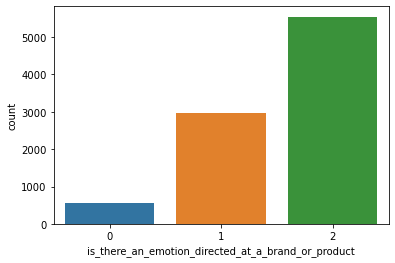

In [82]:
sns.countplot(df.is_there_an_emotion_directed_at_a_brand_or_product);

# Train test split

In [86]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['is_there_an_emotion_directed_at_a_brand_or_product'])
y = df['is_there_an_emotion_directed_at_a_brand_or_product']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [88]:
train_sample = X_train.sample(5, random_state=42)
train_sample.style.set_properties(**{'text-align': 'left'})

,tweet_text
899,"Brilliant move by Apple: before it even begins, Apple wins #SXSW {link}"
7432,{link} Report: Apple to Open Pop-Up Store at #SXSW
8515,omg ÛÏ@mention It's not a rumor: Apple is opening up a temporary store in downtown Austin for #SXSW and the iPad 2 launch {link}
2951,"#sxsw: @mention intrvw @mention ""Govt is not a vending machine [put in $, get svcs], it's a platform; iPhone was a teaching moment"""
8963,"Group #Texting War Heats Up: Fast Society Launches New Android App, Updates iPhone App: #SXSWÛ_ {link}"


# Preprocessing

In [ ]:
regular e

# Namsoo

# Harshitha

## EDA